In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4" # GPU - selection
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [2]:
import os
import glob
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms as T

class UrinKitDataset(Dataset):
    def __init__(self, root_dir, image_size=32):
        self.root_dir = root_dir
        self.image_size = image_size

        self.transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor()
        ])

        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        # 이미지-레이블 경로 추출 + 유효 키트만 추려서 저장
        self.valid_kits = []  # (img_path, label_path, class_idx, kit_index)
        for cls in self.classes:
            cls_path = os.path.join(root_dir, cls)
            for sub in os.listdir(cls_path):
                sub_path = os.path.join(cls_path, sub)
                images = glob.glob(os.path.join(sub_path, "*.jpg"))
                for img_path in images:
                    label_path = img_path.replace(".jpg", ".txt")
                    if not os.path.exists(label_path):
                        continue

                    image = Image.open(img_path).convert("RGB")
                    img_w, img_h = image.size
                    with open(label_path, "r") as f:
                        lines = list(map(str.strip, f.readlines()))
                    labels = []
                    for line in lines:
                        cls_id, x, y, w, h = map(float, line.split())
                        x1 = (x - w / 2) * img_w
                        y1 = (y - h / 2) * img_h
                        x2 = (x + w / 2) * img_w
                        y2 = (y + h / 2) * img_h
                        labels.append([x1, y1, x2, y2, int(cls_id)])

                    labels = np.array(labels)
                    if len(labels) < 6:  # 최소한 1 kit + 1 sensor 이상 필요
                        continue

                    sorted_labels = labels[np.lexsort((labels[:,1], labels[:,0]))]
                    kit_boxes = sorted_labels[:5]
                    sensor_boxes = sorted_labels[5:]
                    kit_boxes = kit_boxes[np.lexsort((kit_boxes[:,0], kit_boxes[:,1]))]

                    for kit_idx, kit in enumerate(kit_boxes):
                        x1, y1, x2, y2, _ = kit
                        mask = (sensor_boxes[:, 0] > x1) & (sensor_boxes[:, 0] < x2) & \
                               (sensor_boxes[:, 1] > y1) & (sensor_boxes[:, 1] < y2)
                        group = sensor_boxes[mask]
                        if len(group) == 11:
                            self.valid_kits.append((img_path, label_path, self.class_to_idx[cls], kit_idx))

    def __len__(self):
        return len(self.valid_kits)

    def __getitem__(self, idx):
        img_path, label_path, class_idx, kit_idx = self.valid_kits[idx]

        image = Image.open(img_path).convert("RGB")
        np_image = np.array(image)
        img_w, img_h = image.size

        with open(label_path, "r") as f:
            label_lines = list(map(str.strip, f.readlines()))

        labels = []
        for line in label_lines:
            cls_id, x, y, w, h = map(float, line.split())
            x1 = (x - w / 2) * img_w
            y1 = (y - h / 2) * img_h
            x2 = (x + w / 2) * img_w
            y2 = (y + h / 2) * img_h
            labels.append([x1, y1, x2, y2, int(cls_id)])

        labels = np.array(labels)
        sorted_labels = labels[np.lexsort((labels[:,1], labels[:,0]))]
        kit_boxes = sorted_labels[:5]
        sensor_boxes = sorted_labels[5:]

        kit_boxes = kit_boxes[np.lexsort((kit_boxes[:,0], kit_boxes[:,1]))]
        current_kit = kit_boxes[kit_idx]

        x1, y1, x2, y2, _ = current_kit
        mask = (sensor_boxes[:, 0] > x1) & (sensor_boxes[:, 0] < x2) & \
               (sensor_boxes[:, 1] > y1) & (sensor_boxes[:, 1] < y2)
        group = sensor_boxes[mask]
        group = group[np.lexsort((group[:,1], group[:,0]))]

        patches = []
        for patch in group:
            px1, py1, px2, py2, _ = patch
            cropped = np_image[round(py1):round(py2), round(px1):round(px2), ::-1]
            cropped_pil = Image.fromarray(cropped)
            transformed = self.transform(cropped_pil)
            patches.append(transformed)

        X = torch.stack(patches)  # (11, 3, H, W)
        Y = torch.tensor(class_idx)

        return X, Y


In [3]:
# from torch.utils.data import DataLoader

# dataset = UrinKitDataset("/home/jupyter-heypaprika/input/urin_by_class", image_size=32)
# dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [4]:
# for X, Y in dataloader:
#     print(X.shape)  # (4, 11, 3, 32, 32)
#     print(Y.shape)  # (4,)
#     print(Y)
#     break


In [5]:
import torch
import torch.nn as nn

class ImageSetViT(nn.Module):
    def __init__(self, patch_dim=3*32*32, embed_dim=256, num_patches=11, num_heads=4, num_classes=25, depth=4):
        super().__init__()
        self.num_patches = num_patches
        self.patch_dim = patch_dim

        # Linear embedding: 각 이미지(=패치)를 벡터로
        self.embedding = nn.Linear(patch_dim, embed_dim)

        # Learnable positional encoding
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # Classification head
        self.head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, x):
        # x: (B, 11, 3, 32, 32)
        B, N, C, H, W = x.shape
        x = x.view(B, N, -1)  # (B, 11, 3*32*32)
        x = self.embedding(x)  # (B, 11, embed_dim)
        x = x + self.pos_embedding  # positional encoding

        x = self.transformer(x)  # (B, 11, embed_dim)
        x = x.mean(dim=1)  # aggregate over patches

        out = self.head(x)  # (B, num_classes)
        return out


In [6]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# 모델 예시 (사용자 모델 정의가 이미 완료되어 있다고 가정)
# from model import ImageSetViT  
# from dataset import UrinKitDataset
model_save_dir = './files'

def train_model(model, train_loader, val_loader, device, num_epochs=10, lr=1e-4):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for X, Y in tqdm(train_loader, desc=f"[Train Epoch {epoch+1}]"):
            X, Y = X.to(device), Y.to(device)

            # (B, 11, 3, 32, 32) → (B, 11*3*32*32)
            # B, P, C, H, W = X.shape
            # X = X.view(B, -1)  # Flatten 11 patches

            outputs = model(X)  # Shape: (B, num_classes)
            loss = criterion(outputs, Y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == Y).sum().item()
            total += Y.size(0)

        acc = correct / total * 100
        print(f"Epoch {epoch+1}: Train Loss: {total_loss:.4f} | Train Acc: {acc:.2f}%")

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X, Y in val_loader:
                X, Y = X.to(device), Y.to(device)
                # B, P, C, H, W = X.shape
                # X = X.view(B, -1)
                outputs = model(X)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == Y).sum().item()
                total += Y.size(0)

        val_acc = correct / total * 100
        print(f"Epoch {epoch+1}: Validation Accuracy: {val_acc:.2f}%\n")

        model_save_path = os.path.join(model_save_dir, f"vit_custom_model_weight_eth_100_2+{epoch}epoch_{val_acc:.2f}.pth")
        torch.save(model.state_dict(), model_save_path)
        print(f'Model saved to {model_save_path}.')

    return model


In [10]:
from torch.utils.data import random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
dataset = UrinKitDataset("/home/jupyter-heypaprika/input/urin_by_class", image_size=32)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=12, shuffle=True)
val_loader = DataLoader(val_set, batch_size=12)

model = ImageSetViT()  # 이미 정의되어 있음
model.load_state_dict(torch.load('./files/vit_custom_model_weight_eth_100_2.pth', map_location=device))



cuda


<All keys matched successfully>

In [ ]:
trained_model = train_model(model, train_loader, val_loader, device, num_epochs=50, lr=1e-4)


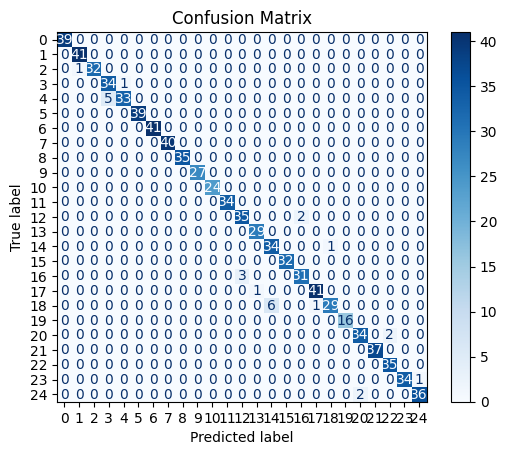

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = ImageSetViT()  # 이미 정의되어 있음
model.to(device)
model.load_state_dict(torch.load('./files/vit_custom_model_weight_eth_100_2+35epoch_93.55.pth', map_location=device))

# Validation
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for X, Y in val_loader:
        X, Y = X.to(device), Y.to(device)
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)

        correct += (predicted == Y).sum().item()
        total += Y.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(Y.cpu().numpy())

val_acc = correct / total * 100

# Confusion Matrix 생성 및 시각화
unique_labels = sorted(list(set(all_labels)))  # 라벨 정렬
cm = confusion_matrix(all_labels, all_preds, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


Validation Accuracy: 97.00%


/opt/tljh/user/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51020 (\N{HANGUL SYLLABLE EUM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/tljh/user/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/tljh/user/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/tljh/user/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48177 (\N{HANGUL SYLLABLE BAEG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/tljh/user/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51656 (\N{HANGUL SYLLABLE JIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figur

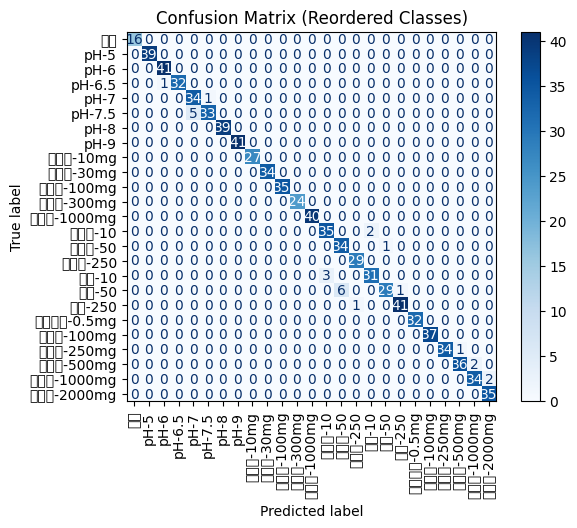

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

model = ImageSetViT()  # 이미 정의되어 있음
model.to(device)
model.load_state_dict(torch.load('./files/vit_custom_model_weight_eth_100_2+35epoch_93.55.pth', map_location=device))

# Validation
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for X, Y in val_loader:
        X, Y = X.to(device), Y.to(device)
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)

        correct += (predicted == Y).sum().item()
        total += Y.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(Y.cpu().numpy())

val_acc = correct / total * 100
print(f"Validation Accuracy: {val_acc:.2f}%")

# 클래스 이름 매핑
idx_to_label = {
    0: 'pH-5', 1: 'pH-6', 2: 'pH-6.5', 3: 'pH-7', 4: 'pH-7.5',
    5: 'pH-8', 6: 'pH-9', 7: '단백질-1000mg', 8: '단백질-100mg', 9: '단백질-10mg',
    10: '단백질-300mg', 11: '단백질-30mg', 12: '비용혈-10', 13: '비용혈-250', 14: '비용혈-50',
    15: '아질산염-0.5mg', 16: '용혈-10', 17: '용혈-250', 18: '용혈-50', 19: '음성',
    20: '포도당-1000mg', 21: '포도당-100mg', 22: '포도당-2000mg', 23: '포도당-250mg', 24: '포도당-500mg'
}

# Confusion Matrix 생성 및 시각화
reorder = [19,0,1,2,3,4,5,6,9,11,8,10,7,12,14,13,16,18,17,15,21,23,24,20,22]

# all_preds와 all_labels도 reorder에 맞게 매핑
# 만약 all_preds나 all_labels 값이 0~24 사이 정수면, reorder 매핑 필요

# label → index 매핑 테이블 생성
label_to_reorder_index = {label: idx for idx, label in enumerate(reorder)}

# 매핑 적용
mapped_preds = [label_to_reorder_index[p] for p in all_preds]
mapped_labels = [label_to_reorder_index[l] for l in all_labels]

# Confusion matrix 생성
cm = confusion_matrix(mapped_labels, mapped_preds, labels=list(range(len(reorder))))

ordered_label_names = [idx_to_label[idx] for idx in reorder]

# Display 시, label 이름을 원래 label 번호로 표시
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ordered_label_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix (Reordered Classes)")
plt.show()


Validation Accuracy: 97.00%


/opt/tljh/user/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/tljh/user/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48177 (\N{HANGUL SYLLABLE BAEG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/tljh/user/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51656 (\N{HANGUL SYLLABLE JIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/tljh/user/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/tljh/user/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(by

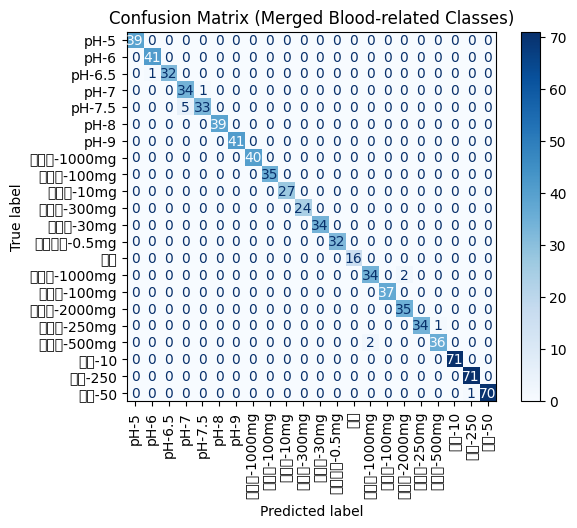

In [22]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib
import matplotlib.pyplot as plt
import torch

matplotlib.rc('font', family='DejaVu Sans')  # or 'Malgun Gothic'
# 모델 로딩
model = ImageSetViT()
model.to(device)
model.load_state_dict(torch.load('./files/vit_custom_model_weight_eth_100_2+35epoch_93.55.pth', map_location=device))

# Validation
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for X, Y in val_loader:
        X, Y = X.to(device), Y.to(device)
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)

        correct += (predicted == Y).sum().item()
        total += Y.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(Y.cpu().numpy())

val_acc = correct / total * 100
print(f"Validation Accuracy: {val_acc:.2f}%")

# 기존 인덱스 → 클래스 이름
idx_to_label = {
    0: 'pH-5', 1: 'pH-6', 2: 'pH-6.5', 3: 'pH-7', 4: 'pH-7.5',
    5: 'pH-8', 6: 'pH-9', 7: '단백질-1000mg', 8: '단백질-100mg', 9: '단백질-10mg',
    10: '단백질-300mg', 11: '단백질-30mg', 12: '비용혈-10', 13: '비용혈-250', 14: '비용혈-50',
    15: '아질산염-0.5mg', 16: '용혈-10', 17: '용혈-250', 18: '용혈-50', 19: '음성',
    20: '포도당-1000mg', 21: '포도당-100mg', 22: '포도당-2000mg', 23: '포도당-250mg', 24: '포도당-500mg'
}

# 25개 클래스 중 합칠 것 지정
merge_mapping = {
    12: '혈뇨-10', 16: '혈뇨-10',     # 비용혈-10 + 용혈-10 → 혈뇨-10
    14: '혈뇨-50', 18: '혈뇨-50',     # 비용혈-50 + 용혈-50 → 혈뇨-50
    13: '혈뇨-250', 17: '혈뇨-250'    # 비용혈-250 + 용혈-250 → 혈뇨-250
}

# 나머지는 기존 이름 유지
for idx, label in idx_to_label.items():
    if idx not in merge_mapping:
        merge_mapping[idx] = label

# 새로운 고유 클래스 이름 리스트 생성
new_labels_set = sorted(set(merge_mapping.values()))
new_label_to_idx = {label: idx for idx, label in enumerate(new_labels_set)}

# all_preds, all_labels 재매핑
mapped_preds = [new_label_to_idx[merge_mapping[p]] for p in all_preds]
mapped_labels = [new_label_to_idx[merge_mapping[l]] for l in all_labels]

# confusion matrix 생성
cm = confusion_matrix(mapped_labels, mapped_preds, labels=list(range(len(new_labels_set))))

# 새로 정리된 클래스 이름
ordered_label_names = new_labels_set

# confusion matrix 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ordered_label_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix (Merged Blood-related Classes)")
plt.show()


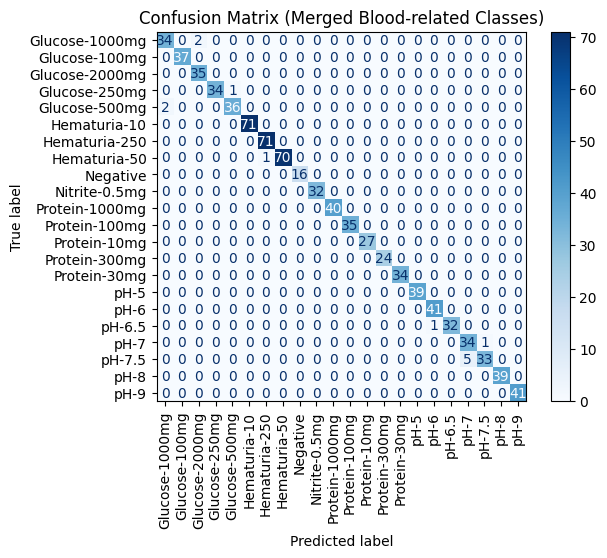

In [24]:

# 기존 인덱스 → 클래스 이름
idx_to_label = {
    0: 'pH-5', 1: 'pH-6', 2: 'pH-6.5', 3: 'pH-7', 4: 'pH-7.5',
    5: 'pH-8', 6: 'pH-9', 7: 'Protein-1000mg', 8: 'Protein-100mg', 9: 'Protein-10mg',
    10: 'Protein-300mg', 11: 'Protein-30mg', 12: 'Occult Blood-10', 13: 'Occult Blood-250', 14: 'Occult Blood-50',
    15: 'Nitrite-0.5mg', 16: 'Hemolysis-10', 17: 'Hemolysis-250', 18: 'Hemolysis-50', 19: 'Negative',
    20: 'Glucose-1000mg', 21: 'Glucose-100mg', 22: 'Glucose-2000mg', 23: 'Glucose-250mg', 24: 'Glucose-500mg'
}

# 25개 클래스 중 합칠 것 지정
merge_mapping = {
    12: 'Hematuria-10', 16: 'Hematuria-10',     # 비용혈-10 + 용혈-10 → 혈뇨-10
    14: 'Hematuria-50', 18: 'Hematuria-50',     # 비용혈-50 + 용혈-50 → 혈뇨-50
    13: 'Hematuria-250', 17: 'Hematuria-250'    # 비용혈-250 + 용혈-250 → 혈뇨-250
}

# 나머지는 기존 이름 유지
for idx, label in idx_to_label.items():
    if idx not in merge_mapping:
        merge_mapping[idx] = label

# 새로운 고유 클래스 이름 리스트 생성
new_labels_set = sorted(set(merge_mapping.values()))
new_label_to_idx = {label: idx for idx, label in enumerate(new_labels_set)}

# all_preds, all_labels 재매핑
mapped_preds = [new_label_to_idx[merge_mapping[p]] for p in all_preds]
mapped_labels = [new_label_to_idx[merge_mapping[l]] for l in all_labels]

# confusion matrix 생성
cm = confusion_matrix(mapped_labels, mapped_preds, labels=list(range(len(new_labels_set))))

# 새로 정리된 클래스 이름
ordered_label_names = new_labels_set

# confusion matrix 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ordered_label_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix (Merged Blood-related Classes)")
plt.show()


In [25]:
import pandas as pd

# confusion matrix를 DataFrame으로 변환
cm_df = pd.DataFrame(cm, index=ordered_label_names, columns=ordered_label_names)

# 엑셀 파일로 저장
cm_df.to_excel('confusion_matrix_merged.xlsx', index=True)

print("Confusion matrix가 'confusion_matrix_merged.xlsx' 파일로 저장되었습니다.")


Confusion matrix가 'confusion_matrix_merged.xlsx' 파일로 저장되었습니다.


In [26]:
import numpy as np

# 정확히 맞춘 샘플 수 (대각선 합)
correct = np.trace(cm)

# 전체 샘플 수 (모든 원소 합)
total = np.sum(cm)

# 정확도 계산
accuracy = correct / total

print(f"Confusion Matrix 기반 Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")


Confusion Matrix 기반 Overall Accuracy: 0.9850 (98.50%)


In [17]:
print()
print(dataset.class_to_idx)


{'pH-5': 0, 'pH-6': 1, 'pH-6.5': 2, 'pH-7': 3, 'pH-7.5': 4, 'pH-8': 5, 'pH-9': 6, '단백질-1000mg': 7, '단백질-100mg': 8, '단백질-10mg': 9, '단백질-300mg': 10, '단백질-30mg': 11, '비용혈-10': 12, '비용혈-250': 13, '비용혈-50': 14, '아질산염-0.5mg': 15, '용혈-10': 16, '용혈-250': 17, '용혈-50': 18, '음성': 19, '포도당-1000mg': 20, '포도당-100mg': 21, '포도당-2000mg': 22, '포도당-250mg': 23, '포도당-500mg': 24}


In [9]:
model_save_dir = './files'
os.makedirs(model_save_dir, exist_ok=True)
model_save_path = os.path.join(model_save_dir, 'vit_custom_model_weight.pth')
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}.')


Model saved to ./files/vit_custom_model_weight.pth.


In [10]:
# model = ImageSetViT() 
# + 추가 학습
trained_model = train_model(model, train_loader, val_loader, device, num_epochs=50, lr=1e-4)


[Train Epoch 1]: 100%|██████████| 290/290 [08:48<00:00,  1.82s/it]


Epoch 1: Train Loss: 135.3117 | Train Acc: 79.83%
Epoch 1: Validation Accuracy: 73.96%



[Train Epoch 2]: 100%|██████████| 290/290 [08:32<00:00,  1.77s/it]


Epoch 2: Train Loss: 118.3377 | Train Acc: 81.62%
Epoch 2: Validation Accuracy: 79.84%



[Train Epoch 3]: 100%|██████████| 290/290 [08:37<00:00,  1.79s/it]


Epoch 3: Train Loss: 123.0730 | Train Acc: 81.53%
Epoch 3: Validation Accuracy: 82.14%



[Train Epoch 4]: 100%|██████████| 290/290 [08:35<00:00,  1.78s/it]


Epoch 4: Train Loss: 111.6628 | Train Acc: 82.48%
Epoch 4: Validation Accuracy: 79.72%



[Train Epoch 5]: 100%|██████████| 290/290 [08:24<00:00,  1.74s/it]


Epoch 5: Train Loss: 121.4959 | Train Acc: 81.10%
Epoch 5: Validation Accuracy: 76.38%



[Train Epoch 6]: 100%|██████████| 290/290 [08:29<00:00,  1.76s/it]


Epoch 6: Train Loss: 121.0709 | Train Acc: 81.36%
Epoch 6: Validation Accuracy: 80.65%



[Train Epoch 7]: 100%|██████████| 290/290 [08:36<00:00,  1.78s/it]


Epoch 7: Train Loss: 113.9777 | Train Acc: 82.34%
Epoch 7: Validation Accuracy: 79.38%



[Train Epoch 8]: 100%|██████████| 290/290 [08:33<00:00,  1.77s/it]


Epoch 8: Train Loss: 113.4308 | Train Acc: 82.69%
Epoch 8: Validation Accuracy: 81.22%



[Train Epoch 9]: 100%|██████████| 290/290 [08:26<00:00,  1.75s/it]


Epoch 9: Train Loss: 116.9395 | Train Acc: 83.35%
Epoch 9: Validation Accuracy: 80.88%



[Train Epoch 10]: 100%|██████████| 290/290 [08:31<00:00,  1.76s/it]


Epoch 10: Train Loss: 109.4477 | Train Acc: 82.66%
Epoch 10: Validation Accuracy: 77.88%



[Train Epoch 11]: 100%|██████████| 290/290 [08:31<00:00,  1.76s/it]


Epoch 11: Train Loss: 101.9800 | Train Acc: 84.18%
Epoch 11: Validation Accuracy: 85.37%



[Train Epoch 12]: 100%|██████████| 290/290 [08:38<00:00,  1.79s/it]


Epoch 12: Train Loss: 108.2597 | Train Acc: 83.61%
Epoch 12: Validation Accuracy: 84.10%



[Train Epoch 13]: 100%|██████████| 290/290 [08:38<00:00,  1.79s/it]


Epoch 13: Train Loss: 114.2033 | Train Acc: 81.99%
Epoch 13: Validation Accuracy: 80.88%



[Train Epoch 14]: 100%|██████████| 290/290 [08:31<00:00,  1.77s/it]


Epoch 14: Train Loss: 107.3334 | Train Acc: 83.61%
Epoch 14: Validation Accuracy: 82.49%



[Train Epoch 15]: 100%|██████████| 290/290 [08:47<00:00,  1.82s/it]


Epoch 15: Train Loss: 103.3451 | Train Acc: 84.30%
Epoch 15: Validation Accuracy: 81.57%



[Train Epoch 16]: 100%|██████████| 290/290 [08:30<00:00,  1.76s/it]


Epoch 16: Train Loss: 106.5660 | Train Acc: 84.44%
Epoch 16: Validation Accuracy: 79.49%



[Train Epoch 17]: 100%|██████████| 290/290 [08:34<00:00,  1.77s/it]


Epoch 17: Train Loss: 95.4424 | Train Acc: 85.11%
Epoch 17: Validation Accuracy: 85.25%



[Train Epoch 18]: 100%|██████████| 290/290 [08:48<00:00,  1.82s/it]


Epoch 18: Train Loss: 122.9341 | Train Acc: 81.82%
Epoch 18: Validation Accuracy: 84.10%



[Train Epoch 19]: 100%|██████████| 290/290 [08:28<00:00,  1.75s/it]


Epoch 19: Train Loss: 94.8844 | Train Acc: 85.34%
Epoch 19: Validation Accuracy: 79.61%



[Train Epoch 20]: 100%|██████████| 290/290 [08:25<00:00,  1.74s/it]


Epoch 20: Train Loss: 94.4772 | Train Acc: 84.99%
Epoch 20: Validation Accuracy: 82.60%



[Train Epoch 21]: 100%|██████████| 290/290 [08:38<00:00,  1.79s/it]


Epoch 21: Train Loss: 113.5547 | Train Acc: 83.23%
Epoch 21: Validation Accuracy: 78.92%



[Train Epoch 22]: 100%|██████████| 290/290 [08:38<00:00,  1.79s/it]


Epoch 22: Train Loss: 93.4381 | Train Acc: 85.34%
Epoch 22: Validation Accuracy: 81.80%



[Train Epoch 23]: 100%|██████████| 290/290 [08:31<00:00,  1.76s/it]


Epoch 23: Train Loss: 97.8417 | Train Acc: 85.28%
Epoch 23: Validation Accuracy: 85.14%



[Train Epoch 24]: 100%|██████████| 290/290 [08:24<00:00,  1.74s/it]


Epoch 24: Train Loss: 97.4854 | Train Acc: 86.14%
Epoch 24: Validation Accuracy: 78.46%



[Train Epoch 25]: 100%|██████████| 290/290 [08:32<00:00,  1.77s/it]


Epoch 25: Train Loss: 96.3670 | Train Acc: 86.14%
Epoch 25: Validation Accuracy: 83.18%



[Train Epoch 26]: 100%|██████████| 290/290 [08:50<00:00,  1.83s/it]


Epoch 26: Train Loss: 85.5443 | Train Acc: 87.53%
Epoch 26: Validation Accuracy: 82.83%



[Train Epoch 27]: 100%|██████████| 290/290 [08:36<00:00,  1.78s/it]


Epoch 27: Train Loss: 100.1750 | Train Acc: 85.54%
Epoch 27: Validation Accuracy: 83.99%



[Train Epoch 28]: 100%|██████████| 290/290 [08:41<00:00,  1.80s/it]


Epoch 28: Train Loss: 91.8145 | Train Acc: 86.95%
Epoch 28: Validation Accuracy: 85.48%



[Train Epoch 29]: 100%|██████████| 290/290 [08:39<00:00,  1.79s/it]


Epoch 29: Train Loss: 84.4352 | Train Acc: 87.24%
Epoch 29: Validation Accuracy: 83.53%



[Train Epoch 30]: 100%|██████████| 290/290 [08:43<00:00,  1.80s/it]


Epoch 30: Train Loss: 93.6645 | Train Acc: 86.11%
Epoch 30: Validation Accuracy: 82.49%



[Train Epoch 31]: 100%|██████████| 290/290 [08:47<00:00,  1.82s/it]


Epoch 31: Train Loss: 91.2231 | Train Acc: 86.98%
Epoch 31: Validation Accuracy: 87.90%



[Train Epoch 32]: 100%|██████████| 290/290 [08:27<00:00,  1.75s/it]


Epoch 32: Train Loss: 86.1245 | Train Acc: 87.21%
Epoch 32: Validation Accuracy: 78.80%



[Train Epoch 33]: 100%|██████████| 290/290 [08:34<00:00,  1.77s/it]


Epoch 33: Train Loss: 97.7741 | Train Acc: 86.03%
Epoch 33: Validation Accuracy: 82.49%



[Train Epoch 34]: 100%|██████████| 290/290 [08:38<00:00,  1.79s/it]


Epoch 34: Train Loss: 80.5526 | Train Acc: 88.19%
Epoch 34: Validation Accuracy: 83.41%



[Train Epoch 35]: 100%|██████████| 290/290 [08:36<00:00,  1.78s/it]


Epoch 35: Train Loss: 90.5141 | Train Acc: 86.83%
Epoch 35: Validation Accuracy: 86.18%



[Train Epoch 36]: 100%|██████████| 290/290 [08:27<00:00,  1.75s/it]


Epoch 36: Train Loss: 83.1187 | Train Acc: 87.47%
Epoch 36: Validation Accuracy: 86.87%



[Train Epoch 37]: 100%|██████████| 290/290 [08:35<00:00,  1.78s/it]


Epoch 37: Train Loss: 86.5858 | Train Acc: 87.76%
Epoch 37: Validation Accuracy: 85.37%



[Train Epoch 38]: 100%|██████████| 290/290 [08:45<00:00,  1.81s/it]


Epoch 38: Train Loss: 80.6323 | Train Acc: 87.67%
Epoch 38: Validation Accuracy: 84.91%



[Train Epoch 39]: 100%|██████████| 290/290 [08:44<00:00,  1.81s/it]


Epoch 39: Train Loss: 79.7460 | Train Acc: 88.56%
Epoch 39: Validation Accuracy: 85.02%



[Train Epoch 40]: 100%|██████████| 290/290 [08:50<00:00,  1.83s/it]


Epoch 40: Train Loss: 84.6997 | Train Acc: 87.70%
Epoch 40: Validation Accuracy: 79.03%



[Train Epoch 41]: 100%|██████████| 290/290 [08:31<00:00,  1.76s/it]


Epoch 41: Train Loss: 76.0156 | Train Acc: 88.76%
Epoch 41: Validation Accuracy: 87.79%



[Train Epoch 42]: 100%|██████████| 290/290 [08:41<00:00,  1.80s/it]


Epoch 42: Train Loss: 80.3622 | Train Acc: 88.36%
Epoch 42: Validation Accuracy: 79.84%



[Train Epoch 43]: 100%|██████████| 290/290 [08:49<00:00,  1.82s/it]


Epoch 43: Train Loss: 95.8277 | Train Acc: 86.55%
Epoch 43: Validation Accuracy: 85.14%



[Train Epoch 44]: 100%|██████████| 290/290 [08:35<00:00,  1.78s/it]


Epoch 44: Train Loss: 77.5271 | Train Acc: 88.88%
Epoch 44: Validation Accuracy: 87.10%



[Train Epoch 45]: 100%|██████████| 290/290 [08:43<00:00,  1.80s/it]


Epoch 45: Train Loss: 70.4427 | Train Acc: 90.03%
Epoch 45: Validation Accuracy: 85.60%



[Train Epoch 46]: 100%|██████████| 290/290 [08:41<00:00,  1.80s/it]


Epoch 46: Train Loss: 70.6699 | Train Acc: 89.46%
Epoch 46: Validation Accuracy: 88.82%



[Train Epoch 47]: 100%|██████████| 290/290 [08:51<00:00,  1.83s/it]


Epoch 47: Train Loss: 97.9500 | Train Acc: 86.06%
Epoch 47: Validation Accuracy: 79.38%



[Train Epoch 48]: 100%|██████████| 290/290 [08:53<00:00,  1.84s/it]


Epoch 48: Train Loss: 69.7971 | Train Acc: 89.89%
Epoch 48: Validation Accuracy: 82.49%



[Train Epoch 49]: 100%|██████████| 290/290 [10:09<00:00,  2.10s/it]


Epoch 49: Train Loss: 71.8248 | Train Acc: 89.11%
Epoch 49: Validation Accuracy: 88.48%



[Train Epoch 50]: 100%|██████████| 290/290 [09:17<00:00,  1.92s/it]


Epoch 50: Train Loss: 77.8933 | Train Acc: 88.62%
Epoch 50: Validation Accuracy: 87.44%



In [12]:
model_save_dir = './files'
os.makedirs(model_save_dir, exist_ok=True)
model_save_path = os.path.join(model_save_dir, 'vit_custom_model_weight_eth_100_2.pth')
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}.')


Model saved to ./files/vit_custom_model_weight_eth_100_2.pth.


In [ ]:
# model = ImageSetViT() 
# + 추가 학습
trained_model = train_model(model, train_loader, val_loader, device, num_epochs=100, lr=1e-4)


In [ ]:
model = ImageSetViT()  
trained_model = train_model(model, train_loader, val_loader, device, num_epochs=30, lr=1e-3)


In [ ]:
# 2. object detection 패치 단위로 안하고, 키트만 detection 해서, ViT 모델에 키트 데이터 넣을 경우 어떻게 결과가 나올지?

# dataset 정의

# ViT 모델 로드



In [ ]:
# 3. classical detection (opencv, 색상 기반)

# object detection으로 패치에 대해서 detection하고, color 기반으로 휴리스틱하게 판정을 내리기?

In [32]:
## ViT 모델 학습시 코드 뼈대 작성
## 학습 :
## object detection 모델에 사용되는 label이 X data를 구성하는 데에 사용됨.
## dir 이름이 Y data를 구성하는 데에 사용됨.

## 검증 :
## 학습과 동일

## 참고) 테스트 :
## object detection 모델의 예측 결과가 X data를 구성하는 데에 직접적으로 사용됨
## Y data는 모델의 예측 결과

import glob
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as T

data_path = "/home/jupyter-heypaprika/datasets/urin_check_dataset/Z-FLIP_unlabelled/"
files = glob.glob(data_path+"*.txt")
image_file_size = glob.glob(data_path+"*.jpg")[0]
image = Image.open(image_file_size).convert("RGB")
np_image = np.array(image)

img_w, img_h = image.size

### X : image to tensor ###

with open(files[1], "r") as file:
    cur_label_xywhn = list(map(str.rstrip, file.readlines()))

print(cur_label_xywhn)

# to transform xywhn to xyxy
def xywhn2xyxy(x, y, w, h, img_w, img_h):
    x1 = (x - w / 2) * img_w
    y1 = (y - h / 2) * img_h
    x2 = (x + w / 2) * img_w
    y2 = (y + h / 2) * img_h
    return x1, y1, x2, y2

cur_label = ["" for _ in range(len(cur_label_xywhn))]

for i in range(len(cur_label)):
    n, x, y, w, h = map(float, cur_label_xywhn[i].split())
    x1, y1, x2, y2 = xywhn2xyxy(x, y, w, h, img_w, img_h)
    cur_label[i] = [x1, y1, x2, y2, int(n)]


xyxy = np.array(cur_label)
sorted_data = xyxy[np.lexsort((xyxy[:,1], xyxy[:,0]))]


kit = sorted_data[:3]
sensor = sorted_data[3:]
kit = kit[np.lexsort((kit[:,0], kit[:,1]))]
groups = []

for k in kit:
    # k[0]: lower bound for x, k[2]: upper bound for x
    # k[1]: lower bound for y, k[3]: upper bound for y
    mask = (sensor[:, 0] > k[0]) & (sensor[:, 0] < k[2]) & \
           (sensor[:, 1] > k[1]) & (sensor[:, 1] < k[3])
    result = sensor[mask]
    result = result[np.lexsort((result[:,1], result[:,0]))]

    groups.append(result)


image_size = 32

transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(),  # Converts to (C, H, W)
        ])


# 각 그룹 출력
batch = []
for group in groups:
    print(f"cur Kit 에 해당하는 sensor 데이터:")
    images = []
    for j, patch in enumerate(group):
        print(patch)
        x1, y1, x2, y2, n = patch
        crop_patch = np_image[round(y1):round(y2), round(x1):round(x2)]
        crop_patch = crop_patch[..., ::-1]
        # v1: 전체 이미지를 그대로 리사이징
        crop_patch_pil = Image.fromarray(crop_patch)
        img = transform(crop_patch_pil)  # (3, 32, 32)
        images.append(img)
    images = torch.stack(images)
    batch.append(images)
batch = torch.stack(batch)

print(batch.shape)

### X : image to tensor, Done ###



### Y : dir to label

['0 0.550258 0.482883 0.792669 0.077674', '1 0.617799 0.486476 0.031260 0.037913', '1 0.329770 0.677449 0.032549 0.039392', '1 0.333755 0.299361 0.033366 0.040691', '0 0.549963 0.680188 0.791086 0.061061', '1 0.525079 0.300167 0.033444 0.041095', '1 0.187318 0.674683 0.032913 0.038827', '1 0.472916 0.680706 0.032978 0.040174', '1 0.572871 0.300507 0.033263 0.040777', '1 0.188825 0.470396 0.032049 0.037992', '1 0.381804 0.299490 0.033687 0.041507', '1 0.520465 0.681194 0.032542 0.039607', '1 0.235907 0.471770 0.032014 0.037578', '1 0.237901 0.298994 0.033299 0.040819', '1 0.615836 0.683158 0.032793 0.040101', '1 0.477110 0.299988 0.033037 0.040756', '1 0.620210 0.300888 0.032191 0.040185', '1 0.331899 0.475316 0.030721 0.036569', '1 0.190821 0.299361 0.033619 0.040581', '1 0.475174 0.480683 0.030734 0.036728', '1 0.283940 0.473679 0.031935 0.037647', '1 0.281818 0.676706 0.032514 0.039516', '0 0.552543 0.300242 0.789979 0.051366', '1 0.567939 0.681674 0.032169 0.039883', '1 0.429138 0.2